In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import bayesnet as bn

np.random.seed(1234)

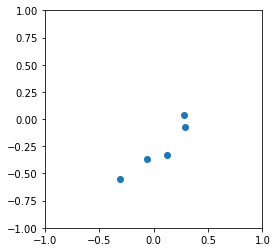

In [2]:
x_train = np.random.uniform(-0.5, 0.5, 5)
y_train = 0.5 * x_train - 0.3 + np.random.normal(scale=0.1, size=x_train.shape)
x_train = np.array([np.ones_like(x_train), x_train]).T

plt.scatter(x_train[:, 1], y_train)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect("equal", adjustable="box")

In [6]:
class BayesianRegressor(bn.Network):
    
    def __init__(self, w=np.zeros(2)):
        super().__init__(w=w)

    def __call__(self, x, y=None):
        self.w_prior = bn.random.MultivariateGaussian(np.zeros(2), np.eye(2), data=self.w)
        self.y = bn.random.Gaussian((x * self.w).sum(axis=-1), 1., data=y)
        if y is None:
            return self.y.mu.value

In [15]:
sample = bn.sampler.metropolis(
    BayesianRegressor(),
    (x_train, y_train),
    downsample=1000,
    w=bn.random.Gaussian(np.zeros(2), 0.05)
)

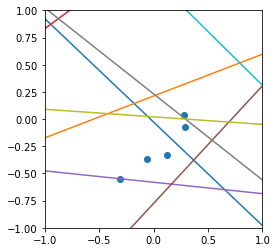

In [16]:
plt.scatter(x_train[:, 1], y_train)

x = np.linspace(-1, 1, 100)
for i, w in enumerate(sample["w"]):
    if i % 10 == 0:
        model = BayesianRegressor(w)
        plt.plot(x, model(np.array([np.ones_like(x), x]).T))
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect("equal", adjustable="box")

In [47]:
model = BayesianRegressor()
optimizer = bn.optimizer.Adam(model, 0.01)
for _ in range(1000):
    model.cleargrad()
    model(x_train, y_train)
    model.log_posterior().backward()
    optimizer.update()

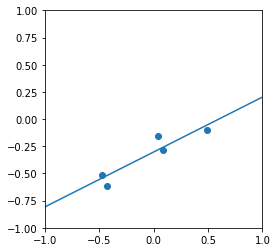

In [48]:
x = np.linspace(-1, 1, 100)
x = np.array([np.ones_like(x), x]).T
plt.plot(x[:, 1], model(x))
plt.scatter(x_train[:, 1], y_train)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect("equal", adjustable="box")